<a href="https://colab.research.google.com/github/PiotrMaciejKowalski/BigData2024/blob/main/colabs/Kr%C3%B3tkie_wprowadzenie_do_Sparka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Setup Sparka

## Utworzenie środowiska pyspark do obliczeń

Tworzymy swoje środowisko z pysparkiem we wenętrzu naszych zasobów chmurowych


In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [2]:
!wget -q dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz

In [3]:
!tar xf spark-3.5.0-bin-hadoop3.tgz

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

In [5]:
!pip install -q findspark

import findspark
findspark.init()

## Utworzenie sesji

Utworzymy testowo sesję aby zobaczyć czy działa. Element ten jest wspólny również gdy systemy sparkowe pracują w sposób ciągły, a nie są tworzone przez naszą sesję.

In [6]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

## Apache Spark

**Apache Spark** to zunifikowany silnik do obliczeń rozproszonych na licencji open-source. Oferuje interfejs pozwalający na programowanie obliczeń na klastrach z domyślną paralelizacją oraz odpornością na awarie.

Ze Sparkiem pracować można w Scali, Pythonie, Javie oraz R.

Jego przewaga nad model Map-Reduce Hadoopa polega na unikaniu zapisów na hdfs tak długo jak to możliwe - i posługiwaniu się RAMem nodów jak długo go wystarcza.

**Komponenty Sparka:**

<img src="https://raw.githubusercontent.com/PiotrMaciejKowalski/kurs-analiza-danych-2022/main/Tydzie%C5%84%206/cluster-overview.png" alt="title" width="500"/>

* Spark "core" - podstawa Sparka z podstawową abstrakcją danych nazywaną RDD
* Spark SQL - komponent pozwalający na operowanie na ustrukturyzowanych danych z wykorzystaniem operacji znanych z SQL - łatwy w użyciu
* Spark MLlib - komponent zawierający algorytmy ML dostępne w Sparku - ML na skalę klastrów
* Spark Streaming - moduł pozwalający na pracę ze strumnieniami danych
* Spark GraphX - komponent do pracy z grafami

**Architektura Sparka:**

<img src="https://raw.githubusercontent.com/PiotrMaciejKowalski/kurs-analiza-danych-2022/main/Tydzie%C5%84%206/spark-stack.png" alt="title" width="500"/>

* driver - proces uruchamiający główną funkcję aplikacji i tworzący SparkContext
* executor(y) - proces uruchomiony dla aplikacji w węźle roboczym (worker node), który uruchamia zadania i przechowuje dane w pamięci lub na dysku. Każda aplikacja ma własne executory
* cluster manager - dostępne opcje: YARN, Mesos, Kubernetes, Standalone

**SparkSession:**
* wprowadzony w Spark 2.0
* składa się ze SparkContextu, SQLContextu oraz HiveContext
* zwykle nazywany w kodzie `spark`
* kroki niezbędne do utworzenia SparkSession w pySparku:

> from pyspark.sql import SparkSession  
> spark = SparkSession.builder.getOrCreate()



## RDD

Podstawowym formatem danych (coś jak tabela w db) jest RDD. Skrót rozwija się następująco:
* R - resilient (elastyczny)
* D - distributed
* D - dataset

Model RDD jest napisany w sposób wspierający przekstrzałcenia Map-Reduce jako domyślny. W związku z powyższym wykazuje się następującymi własnościami:


* immutable - każdy obiekt jest niezmienniczy. Chcesz coś zmienić - musisz utworzyć nowy rdd
* in-memory - przetwarzany głównie w RAM
* lazy evaluated - silnik obliczeniowy wykonuje obliczenia dopiero gdy okażą się konieczne.
* parallel - współbieżny

Z RDD stowarzyszone są dwa rodzaje czynności:
* akcje, oraz
* transformacje

### Transformacje

Modelują czynności jakie możemy chcieć wykonywać na danych. Przekształcenia (map), redukcje (reduce), filtry (filter). Mają charakter opisu skąd się biorą pewne wartości. W naszym ujęciu mogą odpowiadać funkcjom mapper, reducer i podobnym.

_Dla osób, które kojarzą paradygmat funkcyjny programowania - można dodać, że transformacje dotyczą funkcji czystych._

### Akcje

Modelują czynności z uwagi na wynik jaki oczekujemy. Wyświetl, zapisz, wyszukaj. Mają charakter silnie połączony z wynikiem działania.


Aby obliczenia na danych zostały wykonane - musi zostać uruchomiona akcja. Dopiero ona wykona odpowiednie (i tylko te konieczne) transformacje.



## DataFrame

Choć RDD są wszędzie w Sparku, obecnie już się ich nie widzi. Od Sparka w wersji 2.0 zostały przesłonięte nowym interfejsem (zostały spakowane do wnętrza) czegoś nazywanego Ramką Danych (Dataframe). Skojarzenie z dataframe z R lub Pandas Python jest tutaj bardzo naturalne i prawdziwe. DataFrame Sparka były na nich wzorowane i pokrywają się w dużym obszarze składni.

**DataFrame:**
* abstrakcja danych z modułu Spark SQL
* zawiera dodatkowe informacje o strukturze danych (schema)
* pozwala na pracę z danymi wykorzysując zapytania znane z SQL/Hive

Dalej zaprezentujemy jak to się odbywa w praktyce

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Przykładowy processing danych w Spark

## Wczytanie danych do Sparka

W tej części wczytamy sobie nasz plik `flights.csv` do przetwarzania w Spark.

Z uwagi na to, że nasz plik to csv bez nagłówka - trzeba zdefiniować schemat dla danych, które przetwarzamy

Przypomnijmy listę pól
YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,\
DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,\
TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,\
TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,\
CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,\
LATE_AIRCRAFT_DELAY,WEATHER_DELAY

_Sporo ich. Więc najpierw trochę magii (bo nie chce mi się kodować każdego pola ręcznie, a jestem leniwy). Ufam, że przykład pozwoli rozszerzyć zastosowanie do bardziej skomplikowanych zastosowań. Na pocieszenie dodam, że wczytywanie csv bez nagłówka to najgorszy scenariusz w wersji wczytywania w sparku._

In [8]:
pola_zbiorczo = '''YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY'''
pola = pola_zbiorczo.split(',')

A dalej użyjemy funkcji `add(Nazwa, Typ pola, czy może być null)` do zapisania prostego schematu danych

In [9]:
from pyspark.sql.types import StructType, StringType

schemat = StructType()
for pole in pola:
    schemat = schemat.add(pole, StringType(), True)

Przejdźmy do wczytywania

In [18]:
df = spark.read.format('csv').option("header", False).schema(schemat).load('/content/drive/MyDrive/Datasets/Airlines/flights.csv')
df.show(5)

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|AIR_SYSTEM_DELAY|SECURITY_DELAY|AIRLINE_DELAY|LATE_AIRCRAFT_DELAY|WEATHER_DELAY|
+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+-

In [19]:
df.columns

['YEAR',
 'MONTH',
 'DAY',
 'DAY_OF_WEEK',
 'AIRLINE',
 'FLIGHT_NUMBER',
 'TAIL_NUMBER',
 'ORIGIN_AIRPORT',
 'DESTINATION_AIRPORT',
 'SCHEDULED_DEPARTURE',
 'DEPARTURE_TIME',
 'DEPARTURE_DELAY',
 'TAXI_OUT',
 'WHEELS_OFF',
 'SCHEDULED_TIME',
 'ELAPSED_TIME',
 'AIR_TIME',
 'DISTANCE',
 'WHEELS_ON',
 'TAXI_IN',
 'SCHEDULED_ARRIVAL',
 'ARRIVAL_TIME',
 'ARRIVAL_DELAY',
 'DIVERTED',
 'CANCELLED',
 'CANCELLATION_REASON',
 'AIR_SYSTEM_DELAY',
 'SECURITY_DELAY',
 'AIRLINE_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'WEATHER_DELAY']

In [20]:
df.printSchema()

root
 |-- YEAR: string (nullable = true)
 |-- MONTH: string (nullable = true)
 |-- DAY: string (nullable = true)
 |-- DAY_OF_WEEK: string (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FLIGHT_NUMBER: string (nullable = true)
 |-- TAIL_NUMBER: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- SCHEDULED_DEPARTURE: string (nullable = true)
 |-- DEPARTURE_TIME: string (nullable = true)
 |-- DEPARTURE_DELAY: string (nullable = true)
 |-- TAXI_OUT: string (nullable = true)
 |-- WHEELS_OFF: string (nullable = true)
 |-- SCHEDULED_TIME: string (nullable = true)
 |-- ELAPSED_TIME: string (nullable = true)
 |-- AIR_TIME: string (nullable = true)
 |-- DISTANCE: string (nullable = true)
 |-- WHEELS_ON: string (nullable = true)
 |-- TAXI_IN: string (nullable = true)
 |-- SCHEDULED_ARRIVAL: string (nullable = true)
 |-- ARRIVAL_TIME: string (nullable = true)
 |-- ARRIVAL_DELAY: string (nullable = true)
 |-- D

In [21]:
%%time
df.count()

CPU times: user 195 ms, sys: 28 ms, total: 223 ms
Wall time: 20.4 s


5819079

In [22]:
%%time
df.show(15)

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|AIR_SYSTEM_DELAY|SECURITY_DELAY|AIRLINE_DELAY|LATE_AIRCRAFT_DELAY|WEATHER_DELAY|
+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+-

In [23]:
%%time
df.show(1015)

+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|AIR_SYSTEM_DELAY|SECURITY_DELAY|AIRLINE_DELAY|LATE_AIRCRAFT_DELAY|WEATHER_DELAY|
+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+-

# Zapytania Spark-SQL

Zapytania do Sparka kierowane są za pomocą

* składni a.k.a. SQL, lub
* wyrażone w ORM (object relational mapping) czyli obiektowym sposobie na wyrażanie kwerend.

Składniowo wydaje się, że zapytania SQL są łatwiejsze do zapisania. W kilku przypadkach jednak jawne zadanie kolejności obliczeń może pomóc zoptymalizować kształt zapytania.

Zaprezentuje kilka podstawowych sposób na odpytywanie Spark DataFrame kwerendami o różnych naturach. Zawsze podane obe będą w postaci SparkSQL oraz wyrażenia ORM.

## Proste kwerendy

Zanim zacznimy pisać kwerendy należy jeszcze dodać nasz DataFrame do 'przestrzeni nazw tabel' Sparka. Formalnie nazywane jest to widokiem danych

In [24]:
df.createOrReplaceTempView("df")

Wykonajmy prostego Selecta z tego zbioru.

Przypominam, że do uruchomienia sparka potrzebna jest akcja. Np. taki `show()`

In [25]:
spark.sql('select airline, distance from df').show()

+-------+--------+
|airline|distance|
+-------+--------+
|     AS|    1448|
|     AA|    2330|
|     US|    2296|
|     AA|    2342|
|     AS|    1448|
|     DL|    1589|
|     NK|    1299|
|     US|    2125|
|     AA|    1464|
|     DL|    1747|
|     DL|    1199|
|     AA|    2174|
|     DL|    1535|
|     DL|    1590|
|     DL|    1399|
|     AS|    1448|
|     DL|    1448|
|     UA|    1635|
|     AS|    1542|
|     DL|    1426|
+-------+--------+
only showing top 20 rows



In [26]:
df.select('airline','distance').show()

+-------+--------+
|airline|distance|
+-------+--------+
|     AS|    1448|
|     AA|    2330|
|     US|    2296|
|     AA|    2342|
|     AS|    1448|
|     DL|    1589|
|     NK|    1299|
|     US|    2125|
|     AA|    1464|
|     DL|    1747|
|     DL|    1199|
|     AA|    2174|
|     DL|    1535|
|     DL|    1590|
|     DL|    1399|
|     AS|    1448|
|     DL|    1448|
|     UA|    1635|
|     AS|    1542|
|     DL|    1426|
+-------+--------+
only showing top 20 rows



## Sprawniejsze wyświetlanie danych sparkowych

In [27]:
df.select('airline','distance').limit(20).toPandas()

,airline,distance
0,AS,1448
1,AA,2330
2,US,2296
3,AA,2342
4,AS,1448
5,DL,1589
6,NK,1299
7,US,2125
8,AA,1464
9,DL,1747


## Proste grupowania i agregacje

Dalej proste pogrupowanie z polem poddanym agregacji.

In [28]:
%%time
spark.sql('select airline, count(*) as count from df group by airline').show()

+-------+-------+
|airline|  count|
+-------+-------+
|     UA| 515723|
|     NK| 117379|
|     AA| 725984|
|     EV| 571977|
|     B6| 267048|
|     DL| 875881|
|     OO| 588353|
|     F9|  90836|
|     US| 198715|
|     MQ| 294632|
|     HA|  76272|
|     AS| 172521|
|     VX|  61903|
|     WN|1261855|
+-------+-------+

CPU times: user 124 ms, sys: 12.8 ms, total: 136 ms
Wall time: 19.7 s


In [29]:
%%time
df.groupBy('airline').count().show()

+-------+-------+
|airline|  count|
+-------+-------+
|     UA| 515723|
|     NK| 117379|
|     AA| 725984|
|     EV| 571977|
|     B6| 267048|
|     DL| 875881|
|     OO| 588353|
|     F9|  90836|
|     US| 198715|
|     MQ| 294632|
|     HA|  76272|
|     AS| 172521|
|     VX|  61903|
|     WN|1261855|
+-------+-------+

CPU times: user 123 ms, sys: 8.21 ms, total: 131 ms
Wall time: 19 s


## Klauzula sortująca

Możemy dane uporządkować względem kolumny

In [30]:
%%time
spark.sql('select airline, count(*) as count from df group by airline order by count').show()

+-------+-------+
|airline|  count|
+-------+-------+
|     VX|  61903|
|     HA|  76272|
|     F9|  90836|
|     NK| 117379|
|     AS| 172521|
|     US| 198715|
|     B6| 267048|
|     MQ| 294632|
|     UA| 515723|
|     EV| 571977|
|     OO| 588353|
|     AA| 725984|
|     DL| 875881|
|     WN|1261855|
+-------+-------+

CPU times: user 109 ms, sys: 12.9 ms, total: 122 ms
Wall time: 18.4 s


In [31]:
%%time
df.groupBy('airline').count().orderBy('count').show()

+-------+-------+
|airline|  count|
+-------+-------+
|     VX|  61903|
|     HA|  76272|
|     F9|  90836|
|     NK| 117379|
|     AS| 172521|
|     US| 198715|
|     B6| 267048|
|     MQ| 294632|
|     UA| 515723|
|     EV| 571977|
|     OO| 588353|
|     AA| 725984|
|     DL| 875881|
|     WN|1261855|
+-------+-------+

CPU times: user 108 ms, sys: 18 ms, total: 126 ms
Wall time: 17.7 s


Możemy zmienić funkcje agregacji na mniej oczywistą lub zadać ich więcej.


In [32]:
%%time
spark.sql('select airline, max(distance) as maks, min(distance) as min from df group by airline').show()

+-------+----+----+
|airline|maks| min|
+-------+----+----+
|     AA| 993|1005|
|     AS| 987|1009|
|     B6| 997|1005|
|     DL| 991|1005|
|     EV| 999| 100|
|     F9| 993|1005|
|     HA|  84| 100|
|     MQ| 999|1013|
|     NK| 986|1005|
|     OO| 996|1004|
|     UA| 997| 100|
|     US| 993|1009|
|     VX| 954|1067|
|     WN| 999|1005|
+-------+----+----+

CPU times: user 139 ms, sys: 16.3 ms, total: 156 ms
Wall time: 22.9 s


In [33]:
%%time
from pyspark.sql import functions as sf #spark functions

df.groupBy('airline').agg(sf.max('distance').alias('maks'), sf.min('distance').alias('min')).show()

+-------+----+----+
|airline|maks| min|
+-------+----+----+
|     AA| 993|1005|
|     AS| 987|1009|
|     B6| 997|1005|
|     DL| 991|1005|
|     EV| 999| 100|
|     F9| 993|1005|
|     HA|  84| 100|
|     MQ| 999|1013|
|     NK| 986|1005|
|     OO| 996|1004|
|     UA| 997| 100|
|     US| 993|1009|
|     VX| 954|1067|
|     WN| 999|1005|
+-------+----+----+

CPU times: user 158 ms, sys: 13.8 ms, total: 172 ms
Wall time: 23.3 s


## Filtrowanie danych

Bardzo ważne jest oczywiście odflitrowanie części dużego zbioru danych.

_Uwaga pamiętajmy, że leniwie wczytując plik skazałem wszystkie pola na bycie Stringami._

In [34]:
%%time
spark.sql('select airline, count(*) as count from df  where day_of_week = "2" group by airline').show()

+-------+------+
|airline| count|
+-------+------+
|     UA| 74945|
|     NK| 16359|
|     AA|103401|
|     EV| 83541|
|     B6| 37753|
|     DL|128412|
|     OO| 84054|
|     F9| 12991|
|     US| 28496|
|     MQ| 42970|
|     HA| 10516|
|     AS| 24165|
|     VX|  8990|
|     WN|188007|
+-------+------+

CPU times: user 113 ms, sys: 8.96 ms, total: 122 ms
Wall time: 16.8 s


In [35]:
%%time
spark.sql('select airline, count(*) as count from df  where day_of_week = "2" group by airline').show()

+-------+------+
|airline| count|
+-------+------+
|     UA| 74945|
|     NK| 16359|
|     AA|103401|
|     EV| 83541|
|     B6| 37753|
|     DL|128412|
|     OO| 84054|
|     F9| 12991|
|     US| 28496|
|     MQ| 42970|
|     HA| 10516|
|     AS| 24165|
|     VX|  8990|
|     WN|188007|
+-------+------+

CPU times: user 110 ms, sys: 14.8 ms, total: 124 ms
Wall time: 16.9 s


# Prezentacja przetworzonych danych

In [36]:
pdf = spark.sql('select airline, count(*) as count from df  where day_of_week = "2" group by airline').toPandas()

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
pdf

,airline,count
0,UA,74945
1,NK,16359
2,AA,103401
3,EV,83541
4,B6,37753
5,DL,128412
6,OO,84054
7,F9,12991
8,US,28496
9,MQ,42970


<Axes: xlabel='airline'>

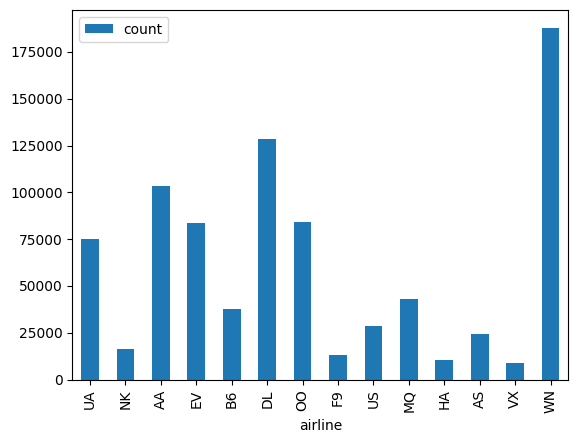

In [43]:
pdf.plot.bar(x='airline', y='count')